In [7]:
# Import necessary libraries
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sqlalchemy import create_engine

# Create a connection to the SQLite database
engine = create_engine('sqlite:///../notebooks/churn_data2.db')

# Query the ‘churn’ table
data_from_db = pd.read_sql('SELECT * FROM churn', engine)

# Fill missing values
data_from_db.fillna(method='ffill', inplace=True)

# Encode categorical variables
label_encoders = {}
for column in data_from_db.select_dtypes(include=['object']).columns:
    label_encoders[column] = LabelEncoder()
    data_from_db[column] = label_encoders[column].fit_transform(data_from_db[column])

# Define features and target
target_col = 'Churn'  # Change to your target column name
X = data_from_db.drop(columns=[target_col])
y = data_from_db[target_col]

# Handle class imbalance
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Try different models
models = [RandomForestClassifier(n_estimators=100, random_state=42), SVC(), XGBClassifier()]
model_names = ['Random Forest', 'SVC', 'XGBoost']

for i, model in enumerate(models):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_names[i]} Accuracy: {accuracy}")

# Ensemble method
estimators = []
model1 = LogisticRegression(max_iter=1000)
estimators.append(('logistic', model1))
model2 = RandomForestClassifier()
estimators.append(('rf', model2))
model3 = SVC()
estimators.append(('svm', model3))

# Create the ensemble model
ensemble = VotingClassifier(estimators)
ensemble.fit(X_train_scaled, y_train)
y_pred = ensemble.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy}")

Random Forest Accuracy: 0.8526570048309179
SVC Accuracy: 0.857487922705314
XGBoost Accuracy: 0.8565217391304348
Ensemble Accuracy: 0.8603864734299517


In [8]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Calculate metrics for each model
for i, model in enumerate(models):
    y_pred = model.predict(X_test_scaled)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_pred)
    print(f"{model_names[i]} Precision: {precision}")
    print(f"{model_names[i]} Recall: {recall}")
    print(f"{model_names[i]} F1 Score: {f1}")
    print(f"{model_names[i]} AUC-ROC: {auc_roc}")

Random Forest Precision: 0.8583815028901735
Random Forest Recall: 0.8493803622497617
Random Forest F1 Score: 0.8538572113080978
Random Forest AUC-ROC: 0.8527019343080346
SVC Precision: 0.8604206500956023
SVC Recall: 0.8579599618684461
SVC F1 Score: 0.8591885441527446
SVC AUC-ROC: 0.8574814500821173
XGBoost Precision: 0.8594646271510517
XGBoost Recall: 0.8570066730219257
XGBoost F1 Score: 0.8582338902147971
XGBoost AUC-ROC: 0.8565150896941166


In [9]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV object to the data
grid_search.fit(X_train_scaled, y_train)

# Print the best parameters and the best score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 100}
Best Score: 0.8460984865069981


In [10]:
# Train the model with the best parameters
best_params = grid_search.best_params_
rf_model = RandomForestClassifier(n_estimators=best_params['n_estimators'], 
                                  max_depth=best_params['max_depth'], 
                                  min_samples_split=best_params['min_samples_split'], 
                                  random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

print(f"Random Forest Accuracy: {accuracy}")
print(f"Random Forest Precision: {precision}")
print(f"Random Forest Recall: {recall}")
print(f"Random Forest F1 Score: {f1}")
print(f"Random Forest AUC-ROC: {auc_roc}")

Random Forest Accuracy: 0.8536231884057971
Random Forest Precision: 0.8545627376425855
Random Forest Recall: 0.8570066730219257
Random Forest F1 Score: 0.8557829604950024
Random Forest AUC-ROC: 0.8535767939056739


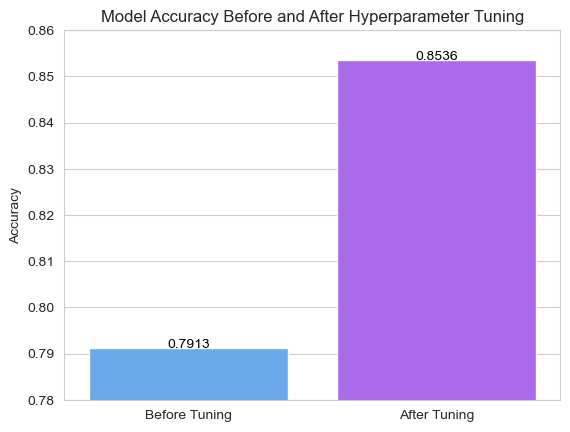

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style to 'whitegrid' for a nice background
sns.set_style("whitegrid")

# Accuracy before and after tuning
accuracy_before = 0.7913
accuracy_after = 0.8536

# Create a bar plot with seaborn
bar_plot = sns.barplot(x=['Before Tuning', 'After Tuning'], y=[accuracy_before, accuracy_after], palette="cool")

# Add the values on top of each bar
for i, value in enumerate([accuracy_before, accuracy_after]):
    bar_plot.text(i, value, round(value, 4), color='black', ha="center")

plt.ylim([0.78, 0.86])  # Adjust y-axis limits
plt.ylabel('Accuracy')
plt.title('Model Accuracy Before and After Hyperparameter Tuning')
plt.show()